In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from langsmith.schemas import DatasetShareSchema
from numpy.testing.print_coercion_tables import print_cancast_table
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from math import ceil
import re

from sympy import reduced
from torch.export import export_for_training

In [5]:
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 50

## 1. Data Cleanup

### 1.1 Data Import 

In [6]:
data = pd.read_csv("../data/BGG_Data_Set.csv", sep=";", header=0)

### 1.2 Rough Cleaning: Dropping of colums, duplicate datapoints, correcting DTypes

In [7]:
data = data.drop(columns=['ID'], axis=1)

In [8]:
init_shape = data.shape[0]
data = data.drop_duplicates()
print(f"Dropped {init_shape - data.shape[0]} duplicate rows")

Dropped 3 duplicate rows


In [9]:
def clean_play_time(value):
    try:
        # If it's already a number, return as-is
        if isinstance(value, (int, float)):
            return value
        # Remove non-numeric characters and attempt conversion
        if isinstance(value, str):
            value = value.strip().lower()
            word_to_num = {
                'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
                'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
                'eleven': 11, 'twelve': 12}

            # Find a number or number word in the string
            match = re.search(r'\b(\d+|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve)\b', value,
                              re.IGNORECASE)
            if not match:
                return np.nan

            number_str = match.group().lower()
            # Convert number word to integer, if necessary
            number = int(number_str) if number_str.isdigit() else word_to_num.get(number_str, None)

            if number is None:
                return np.nan  # or raise ValueError("Invalid number format")

            # Check for 'hour' or 'hours' in the string
            if 'hour' in value:
                return number * 60  # Convert hours to minutes

            # Default case: Assume the number is already in minutes
            return number
    except:
        return np.nan


def clean_min_players(value: int):
    return np.nan if value < 1 else value


def clean_max_players(row):
    if row['Max Players'] < 1:
        return np.nan
    if not pd.isna(row['Min Players']) and row['Max Players'] < row['Min Players']:
        return np.nan
    return row['Max Players']


def clean_numerics(value):
    if isinstance(value, str):
        # Remove any non-numeric characters (except the dot for decimal numbers)
        cleaned_value = ''.join(c for c in value if c.isdigit() or c in [',', '.'])
        cleaned_value = cleaned_value.replace(',', '.')

        # If there is any valid number left after cleaning, return as float
        if cleaned_value:
            try:
                return float(cleaned_value)
            except ValueError:
                return np.nan  # If conversion fails, return None
    elif isinstance(value, (int, float)):
        return value  # Return the value as-is if it's already numeric

    return np.nan  # Return None for other cases (e.g., None, non-numeric strings)


def transform_into_lists(value):
    if isinstance(value, str):
        # Split the string by commas, strip leading/trailing spaces from each item
        return [item.strip() for item in value.split(',')]
    return []  # Return an empty list for non-string values or empty strings


data['Year Published'] = pd.to_numeric(data['Year Published'], errors='coerce')

data['Min Players'] = data['Min Players'].apply(clean_min_players)
data['Max Players'] = data.apply(clean_max_players, axis=1)

data['Play Time'] = data['Play Time'].apply(clean_play_time)
data['Rating Average'] = data['Rating Average'].apply(clean_numerics)
data['Complexity Average'] = data['Complexity Average'].apply(clean_numerics)

data['Mechanics'] = data['Mechanics'].apply(transform_into_lists)
data['Domains'] = data['Domains'].apply(transform_into_lists)

## 2. Data Analysis and Cleaning
### 2.1 General Statistics

In [10]:
def show_gen_stats(data: pd.DataFrame):
    general_stats = data.describe().T

    # Remove the 25/50/75% columns, as these will be shown in the boxplots
    delete_cols = ['25%', '50%', '75%']
    general_stats = general_stats.drop(delete_cols, axis=1)
    # Convert the 'count' column to a percentage of NaNs and rename the column
    general_stats['perc missing'] = 100 * (1 - general_stats['count'] / data.shape[0])
    general_stats['amount missing'] = data.shape[0] - general_stats['count']

    styled_general_stats = general_stats.style.background_gradient(cmap='Blues', axis=None,
                                                                   subset=['perc missing', 'amount missing'])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greens', axis=None, subset=['mean', ])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Reds', axis=None, subset=['std', ])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Purples', axis=None, subset=['min', ])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greys', axis=None, subset=['max', ])
    # Set a format for each column (amount of digits after the comma)

    display(styled_general_stats.format({
        'count': '{:,.2f}',
        'perc missing': '{:,.2f}',
        'amount missing': '{:,.0f}',
        'mean': '{:.2f}',
        'std': '{:.2f}',
        'min': '{:.2f}',
        'max': '{:.2f}'})
    )
    return general_stats


general_stats = show_gen_stats(data)

,count,mean,std,min,max,perc missing,amount missing
Year Published,"18,304.00",1984.31,214.81,-3500.00,2022.00,10.02,"2,039"
Min Players,"20,294.00",2.03,0.98,1.00,100.00,0.24,49
Max Players,"20,179.00",5.72,15.30,1.00,999.00,0.81,164
Play Time,"18,309.00",90.41,541.86,0.00,60000.00,10.00,"2,034"
Min Age,"20,343.00",9.62,3.89,0.00,150.00,0.00,0
Users Rated,"20,343.00",840.97,3511.56,30.00,102214.00,0.00,0
Rating Average,"18,309.00",6.40,0.93,1.05,9.54,10.00,"2,034"
BGG Rank,"20,343.00",10172.89,5872.83,1.00,20344.00,0.00,0
Complexity Average,"20,343.00",1.99,0.85,0.00,5.00,0.00,0
Owned Users,"20,320.00",1408.46,5040.18,0.00,155312.00,0.11,23


### 2.2 Boxplots

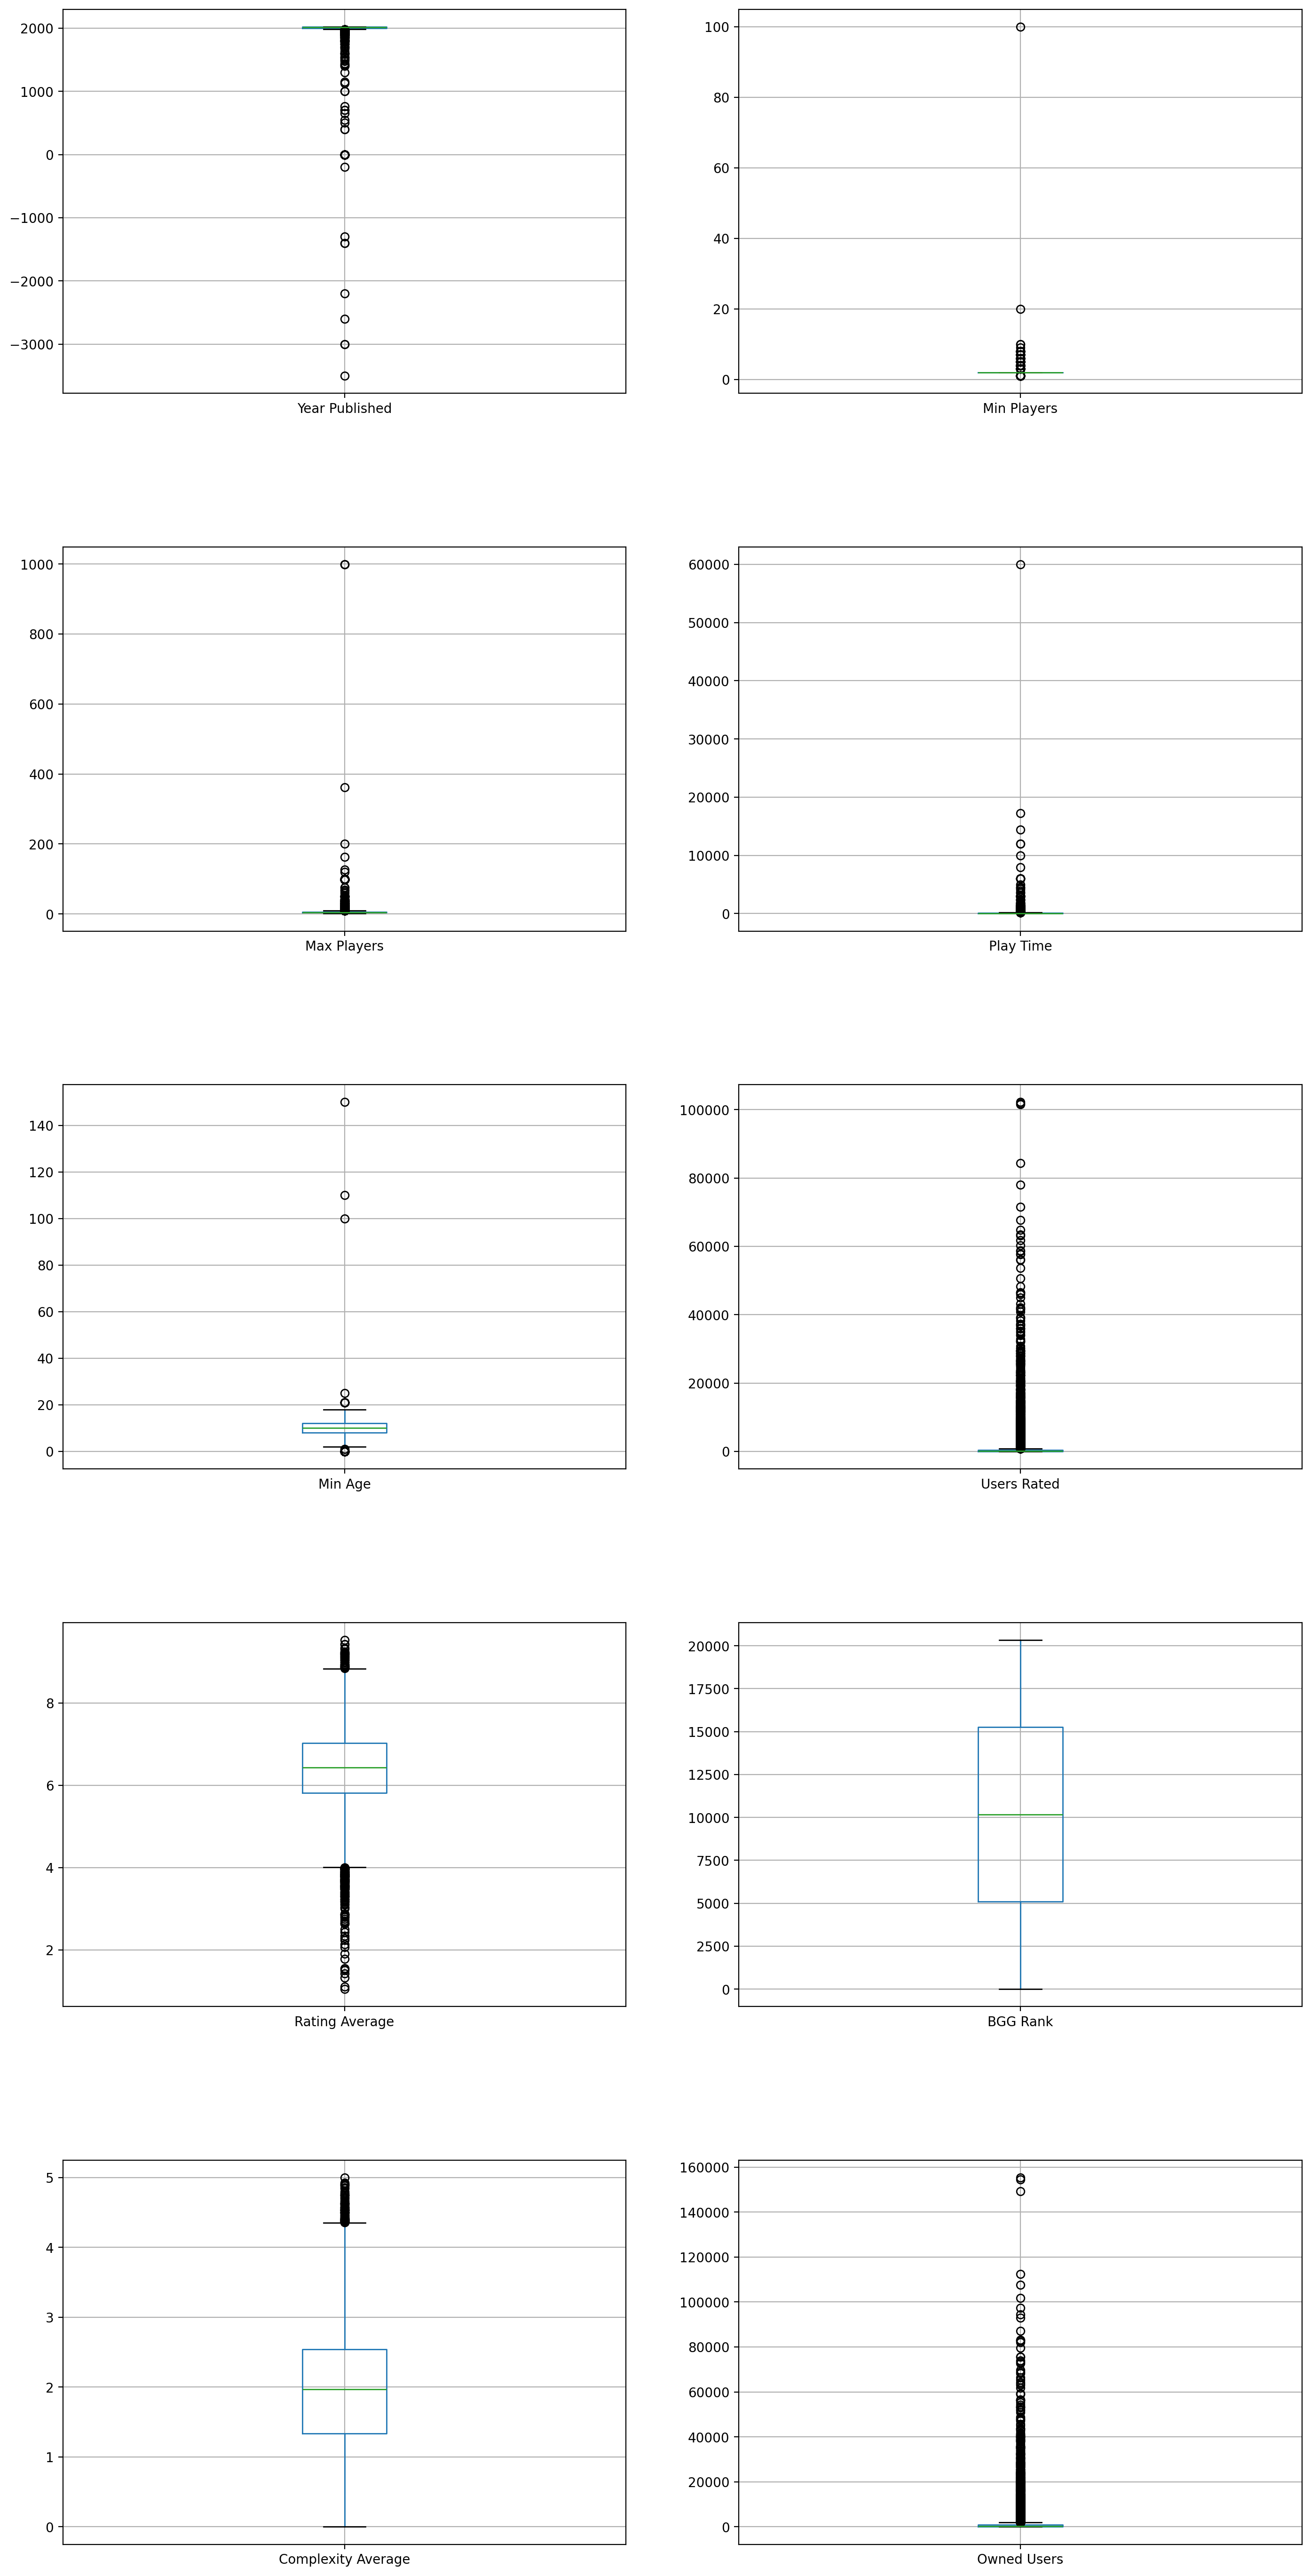

In [11]:
# The amount of sub-plot columns and rows in the output plot
fig_cols = 2
fig_rows = ceil(len(general_stats) / fig_cols)
grid = (fig_rows, fig_cols)

# Create Figure and axes objects
fig, ax = plt.subplots(*grid, figsize=(17, 35), gridspec_kw={'hspace': .4})
# The axes that will be used
used_axes = ax[np.unravel_index(range(len(general_stats)), grid)]

#Make one boxplot per unit of measure 
for i, column in enumerate(general_stats.index):
    _ = data.boxplot(column=column, ax=used_axes[i])

plt.show()

### 2.3 Feature Engineering

In our prediction model: we'll use the following features to predict the target values:
- Year published
- Min Players
- Max Players
- Play Time
- Min Age
- Mechanics
- Domains

Mechanics and Domain will be feature engineered later in the research.

#### 2.3.1 Year published
- 2039 NaN values
- Very long but small tail to the lowest values
- Applying binning capture this tail in usable value: casting tail to pre-1960's.
    - this ensures that the amount of games per bin is in the same order of magnitude as the closest decades
    - We could also argue that it doesn't matter which year it is, as long as it's considered a 'historic' game for the players who have judged it.
- Using median year for NaN values (instead of mean: disregarding the influence of the tail)

In [12]:
median_year = data['Year Published'].median()
year_published_nan_values = data['Year Published'].isnull().sum()

data['Year Published'] = data['Year Published'].fillna(median_year)
print(f"Replaced {year_published_nan_values - data['Year Published'].isnull().sum()} NaN values")

Replaced 2039 NaN values


In [13]:
decade_bins = [-3600, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
decade_labels = ['pre-60s', '60s', '70s', '80s', '90s', '00s', '10s', '20s']

data['Year Published Bins'] = pd.cut(data['Year Published'], bins=decade_bins, labels=decade_labels)

#### 2.3.2 Min & Max Players
- 49 and 146 NaN Values
- Some outliers:
 - outliers of Min Players: delete rows over 99.9th quantile
 - outliers of Max Players: clip at 100

In [14]:
imputer = KNNImputer(n_neighbors=2)
columns_to_impute = ["Min Players", "Max Players"]

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

In [15]:
min_players_99_9_quantile = data['Min Players'].quantile(.999)
min_players_orig = data.shape[0]
data = data[data['Min Players'] <= min_players_99_9_quantile]
print(f"Dropped {min_players_orig - data.shape[0]} rows.")

Dropped 5 rows.


In [16]:
data['Max Players'] = data['Max Players'].clip(upper=100)

#### 2.3.3 Play Time
- Clip & Binning!

In [17]:
data['Play Time'] = data['Play Time'].clip(upper=659)
play_time_bins = [0, 15, 30, 45, 60, 90, 120, 180, 240, 360, 660]
play_time_labels = ['15 min', '30 min', '45 min', '1 hr', '1.5 hr', '2 hrs', '3 hrs', '4 hrs', '6 hrs', '+6 hrs']

data['Play Time Bins'] = pd.cut(data['Play Time'], bins=play_time_bins, labels=play_time_labels)

#### 2.3.4 Min Age
- No NaN values
- Clip the bad values to min age 21.

TODO: 0 values aanpassen --> gemiddelde pakken

In [18]:
data['Min Age'] = data['Min Age'].apply(lambda x: np.nan if x < 2 else x)
data['Min Age'] = data['Min Age'].fillna(data['Min Age'].median())
data['Min Age'] = data['Min Age'].clip(upper=21)

#### 2.3.5 Others

##### 2.3.5.1 Users Rated
- No NaN values
- Deleting this column as this isn't a feature a game in development will have


In [19]:
data = data.drop(columns=['Users Rated'], axis=1)

##### 2.3.5.2 BGG Rank
- No Missing values
- No outliers
- Doesn't correlate exactly with Rating Average: 73%
- We'll drop this column: even though the correlation isn't very high, it seems logical this value is a derivative of the other targets, rathen than the causation of the other targets

In [20]:
print(data[['Rating Average', 'BGG Rank']].corr())
data = data.drop(columns='BGG Rank', axis=1)

                Rating Average  BGG Rank
Rating Average        1.000000 -0.738946
BGG Rank             -0.738946  1.000000


### 2.4 Cleanup Targets

#### 2.4.1 Owned Users
- 23 missing values --> Not filling in as this is a target
- long right tail: Binning the values to 10 categories
- Replacing Owned Users with Popularity Score

In [21]:
#TODO: Experiment with a log transformer as an alternative to binning

owned_users_bins = [0, 75, 150, 225, 300, 500, 750, 1000, 2000, 4000, 200000] # op basis van pd.qcut results
popularity_labels = [i for i in range(1, 11)]
data['Popularity Score'] = pd.to_numeric(pd.cut(data['Owned Users'], bins=owned_users_bins, labels=popularity_labels))

In [22]:
data['Popularity Score'].info()

<class 'pandas.core.series.Series'>
Index: 20338 entries, 0 to 20342
Series name: Popularity Score
Non-Null Count  Dtype  
--------------  -----  
20314 non-null  float64
dtypes: float64(1)
memory usage: 317.8 KB


#### 2.4.2 Complexity Average
- No missing data
- No outliers
- 2.7K values with 0 complexity.

In [23]:
data['Complexity Average'].describe()
data['Complexity Average'].value_counts(bins=[0, 1, 2, 3, 4, 5]).sort_index()

count    20338.000000
mean         1.990826
std          0.848742
min          0.000000
25%          1.333300
50%          1.965500
75%          2.544100
max          5.000000
Name: Complexity Average, dtype: float64

(-0.001, 1.0]    2732
(1.0, 2.0]       9042
(2.0, 3.0]       6147
(3.0, 4.0]       2096
(4.0, 5.0]        321
Name: count, dtype: int64

#### 2.4.3 Rating Average

In [24]:
data['Rating Average'].describe()

count    18304.000000
mean         6.403425
std          0.934506
min          1.046270
25%          5.818660
50%          6.429275
75%          7.029423
max          9.535440
Name: Rating Average, dtype: float64

### 2.5 Finishing touches
- Dropping all rows with Na values in target and features

In [25]:
cleaned_data = data[[
    'Name',
    'Year Published Bins',
    'Min Players',
    'Max Players',
    'Play Time Bins',
    'Min Age',
    'Mechanics',
    'Domains',
    'Rating Average',
    'Complexity Average',
    'Popularity Score']].copy()
_ = show_gen_stats(cleaned_data)

,count,mean,std,min,max,perc missing,amount missing
Min Players,"20,338.00",2.02,0.68,1.00,8.00,0.00,0
Max Players,"20,338.00",5.55,8.87,1.00,100.00,0.00,0
Min Age,"20,338.00",10.22,2.69,2.00,21.00,0.00,0
Rating Average,"18,304.00",6.40,0.93,1.05,9.54,10.00,"2,034"
Complexity Average,"20,338.00",1.99,0.85,0.00,5.00,0.00,0
Popularity Score,"20,314.00",4.84,2.70,1.00,10.00,0.12,24


In [26]:
init_len = cleaned_data.shape[0]
cleaned_data = cleaned_data.dropna(axis=0, subset=['Rating Average', 'Play Time Bins', 'Popularity Score'])
print(f"Dropped {init_len - cleaned_data.shape[0]} rows.")
_ = show_gen_stats(cleaned_data)

Dropped 2562 rows.


,count,mean,std,min,max,perc missing,amount missing
Min Players,"17,776.00",2.03,0.68,1.00,8.00,0.00,0
Max Players,"17,776.00",5.54,8.76,1.00,100.00,0.00,0
Min Age,"17,776.00",10.23,2.70,2.00,21.00,0.00,0
Rating Average,"17,776.00",6.41,0.92,1.05,9.54,0.00,0
Complexity Average,"17,776.00",1.99,0.84,0.00,5.00,0.00,0
Popularity Score,"17,776.00",4.90,2.70,1.00,10.00,0.00,0


### 2.6 Histograms

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Year Published Bins')

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Play Time Bins')

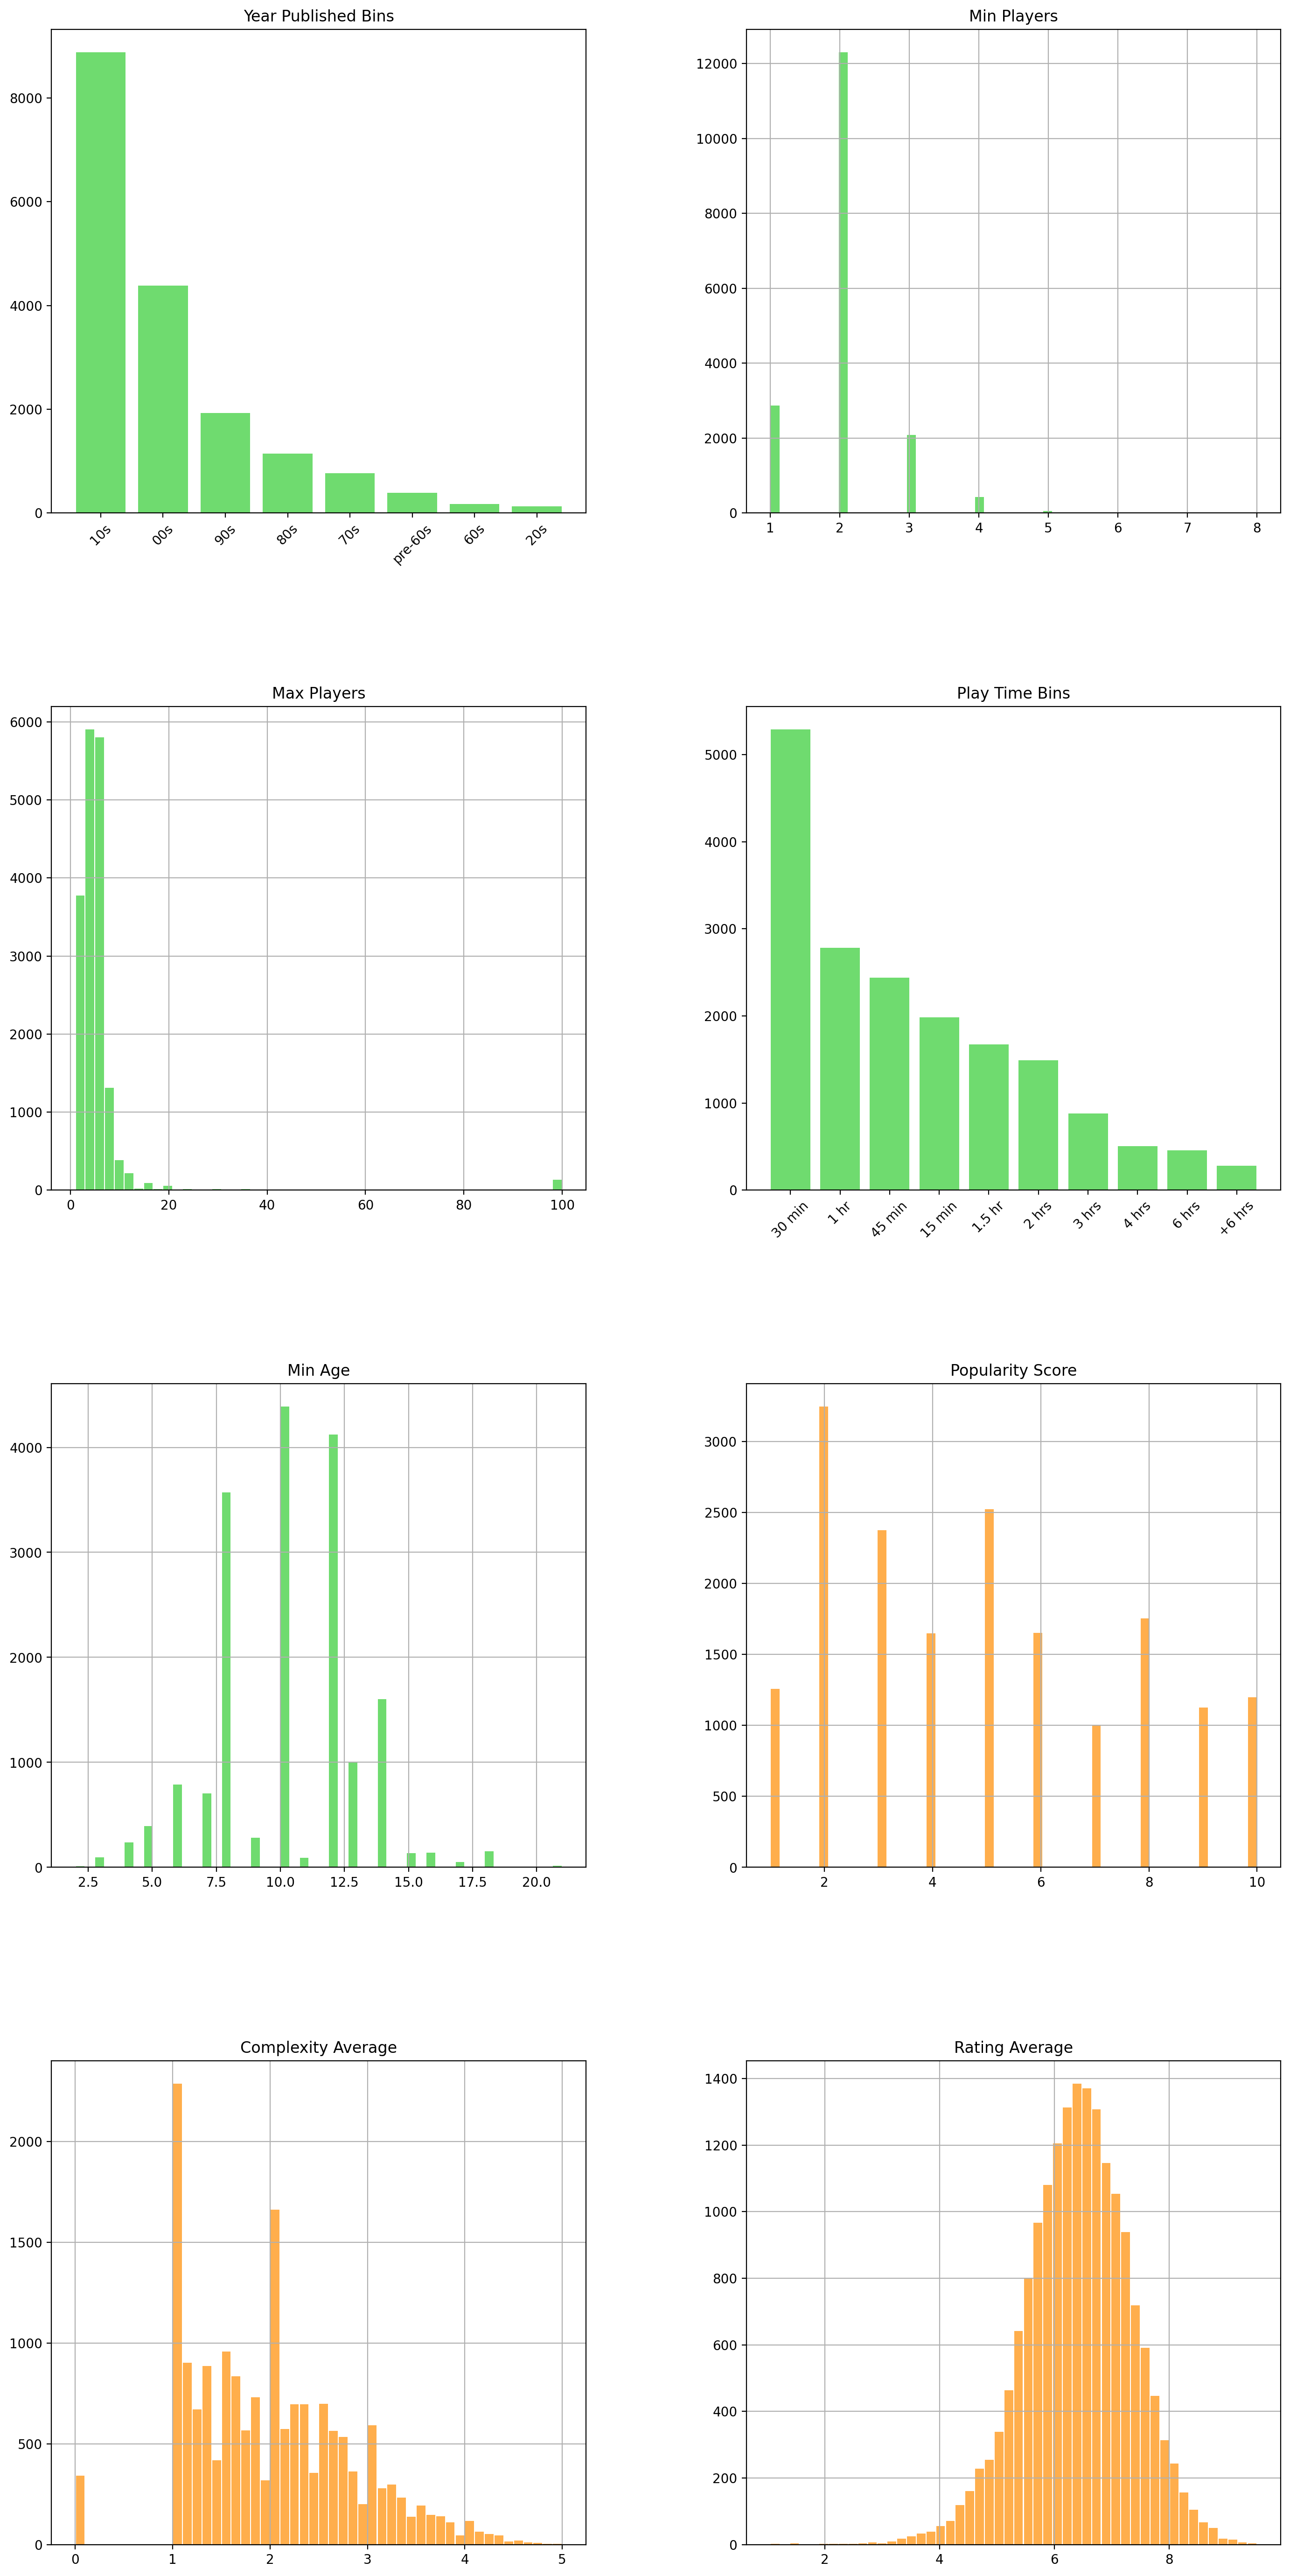

In [27]:
hist_cols = [
    'Year Published Bins',
    'Min Players',
    'Max Players',
    'Play Time Bins',
    'Min Age',
    'Popularity Score',
    'Complexity Average',
    'Rating Average'
]

targets = ['Popularity Score', 'Complexity Average', 'Rating Average']

hist_data = cleaned_data[hist_cols].copy()
fig_cols = 2
fig_rows = ceil(len(hist_cols) / fig_cols)
grid = (fig_rows, fig_cols)

# Create Figure and axes objects
fig, ax = plt.subplots(*grid, figsize=(17, 35), gridspec_kw={'hspace': .4})

# The axes that will be used
used_axes = ax[np.unravel_index(range(len(hist_cols)), grid)]

#Make one histplot per unit of measure 
for i, column in enumerate(hist_cols):
    color = "limegreen" if column not in targets else "darkorange"
    if 'Bins' in column:
        category_counts = hist_data[column].value_counts()
        used_axes[i].bar(
            category_counts.index.astype(str),  # Convert categories to strings
            category_counts.values,
            alpha=0.7,
            color=color,
        )
        used_axes[i].set_title(column)
        used_axes[i].tick_params(axis='x', rotation=45)

    else:
        _ = hist_data.hist(
            column=column,
            ax=used_axes[i],
            color=color,
            alpha=0.7,
            bins=50,
            rwidth=0.9)

plt.show(fig)

### 2.8 List Features
#### 2.8.1 Domains

In [28]:
print(f"Empty Data Points: {cleaned_data['Domains'].apply(lambda x: len(x) == 0).sum()}/{cleaned_data.shape[0]}")

doms = cleaned_data['Domains'].explode().value_counts()
print(f"Amount of unique domains: {len(doms)}")
doms

Empty Data Points: 9238/17776
Amount of unique domains: 8


Domains
Wargames              2706
Strategy Games        1886
Family Games          1860
Thematic Games        1004
Abstract Games         897
Children's Games       716
Party Games            521
Customizable Games     245
Name: count, dtype: int64

In [29]:
dom_combs = cleaned_data["Domains"].apply(lambda x: tuple(sorted(x))).value_counts().sort_index()
print(f"Amount of different combinations: {len(dom_combs)}")

dom_combs

Amount of different combinations: 39


Domains
()                                                  9238
(Abstract Games,)                                    727
(Abstract Games, Children's Games)                    21
(Abstract Games, Children's Games, Wargames)           1
(Abstract Games, Customizable Games)                   2
(Abstract Games, Family Games)                        92
(Abstract Games, Party Games)                          4
(Abstract Games, Strategy Games)                      39
(Abstract Games, Strategy Games, Thematic Games)       1
(Abstract Games, Wargames)                            10
(Children's Games,)                                  589
(Children's Games, Family Games)                      96
(Children's Games, Family Games, Party Games)          1
(Children's Games, Party Games)                        4
(Children's Games, Wargames)                           4
(Customizable Games,)                                191
(Customizable Games, Strategy Games)                  23
(Customizable Games, Th

#### 2.8.2 Mechanics
see mechanics_imputation.ipynb for research

In [30]:
# cleaned_data.to_pickle('data/cleaned_data_wo_mechanics.pkl')

In [31]:
cleaned_data = pd.read_pickle('../data/cleaned_data_with_clusters.pkl')

##  3 Correlation Matrix

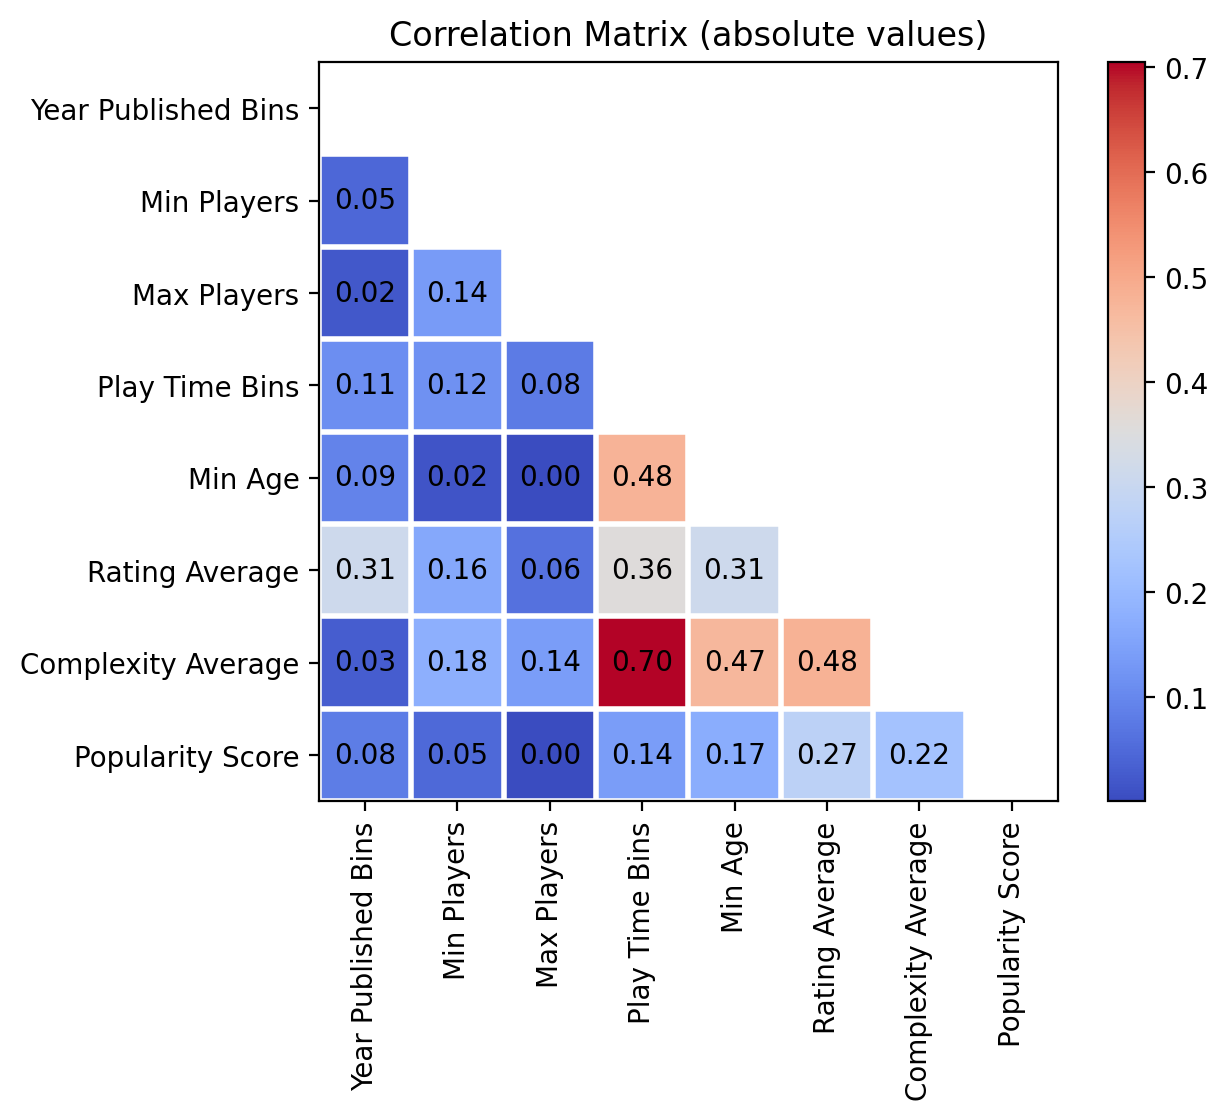

In [32]:
corr_df = cleaned_data.copy().apply(lambda col: col.cat.codes if col.dtypes.name == 'category' else col)
corr_df = corr_df.drop(columns=corr_df.select_dtypes(['object']).columns)
corr = corr_df.corr()
ax_names = corr.columns.tolist()
corr.index = ax_names
corr.columns = ax_names
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

_ = plt.imshow(corr.mask(mask).abs(), cmap='coolwarm', interpolation='nearest')
_ = plt.colorbar()
_ = plt.xticks(np.arange(len(ax_names)), ax_names, rotation=90)
_ = plt.yticks(np.arange(len(ax_names)), ax_names)

plt.grid(False)

_ = plt.xticks(np.arange(-.5, len(ax_names), 1), minor=True)
_ = plt.yticks(np.arange(-.5, len(ax_names), 1), minor=True)
plt.tick_params(which='minor', bottom=False, left=False)
plt.grid(which='minor', color='w', linestyle='-', linewidth=2)

# Display the correlation values on the matrix
for i in range(len(ax_names)):
    for j in range(len(ax_names)):
        # Check if the value is not masked (in the upper triangle)
        if not mask[i, j]:
            # Display the correlation value (rounded for readability)
            _ = plt.text(j, i, f'{abs(corr.iloc[i, j]):.2f}', ha='center', va='center', color='black')

_ = plt.title("Correlation Matrix (absolute values)")

hoge waardes tussen : 
- complexity en min age
- complexity en rating average


## 4. Model Training
### 4.1 Normalisation and prepping of Dataset

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler


def binarize_columns(df, columns):
    mlb_dict = {}
    for column_name in columns:

        if not all(isinstance(x, list) for x in df[column_name]):
            raise ValueError(f"The column '{column_name}' must contain lists of labels.")

        mlb = MultiLabelBinarizer()
        encoded_data = mlb.fit_transform(df[column_name])
        encoded_df = pd.DataFrame(encoded_data, columns=[f"{column_name}_{cls}" for cls in mlb.classes_],
                                  index=df.index)
        df = pd.concat([df.copy(), encoded_df], axis=1)
        mlb_dict[column_name] = mlb

    return df, mlb_dict


def scale_columns(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])

    return df, scaler


def cat_code(df, columns):
    for col in columns:
        df[col] = df[col].astype('category').cat.codes

    return df


def prep_df(df: pd.DataFrame):
    encoded_df = df.copy()

    # Encoding Nominal Features
    encoded_df, mlb_dict = binarize_columns(encoded_df, ['Domains', 'Clusters'])

    # Encoding Ordinal Features
    encoded_df = cat_code(encoded_df, ['Year Published Bins', 'Play Time Bins'])

    # Scaling
    encoded_df, scaler = scale_columns(encoded_df,
                                       ['Min Players', 'Max Players', 'Min Age'])

    # Dropping now-defunct columns
    encoded_df = encoded_df.drop(columns=['Name', 'Mechanics', 'Domains', 'Clusters'])

    return encoded_df, mlb_dict, scaler

In [34]:
encoded, mlbs, scaler = prep_df(cleaned_data)
encoded.head()

,Year Published Bins,Min Players,Max Players,Play Time Bins,Min Age,Rating Average,Complexity Average,Popularity Score,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Wargames,Clusters_0,Clusters_1,Clusters_2,Clusters_3,Clusters_4,Clusters_5,Clusters_6,Clusters_7
0,6,-1.502836,-0.176112,5,1.394576,8.79244,3.8604,10.0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,1,0
1,6,-0.037141,-0.176112,3,1.024598,8.61278,2.8405,10.0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0
2,6,-0.037141,-0.176112,5,1.394576,8.66337,3.9129,10.0,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0
3,6,-1.502836,-0.061961,5,0.654621,8.43254,3.2406,10.0,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0
5,6,-1.502836,-0.176112,5,1.394576,8.87363,3.5472,10.0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,0


### 4.2 Dimensionality Reduction
#### 4.2.1 PCA

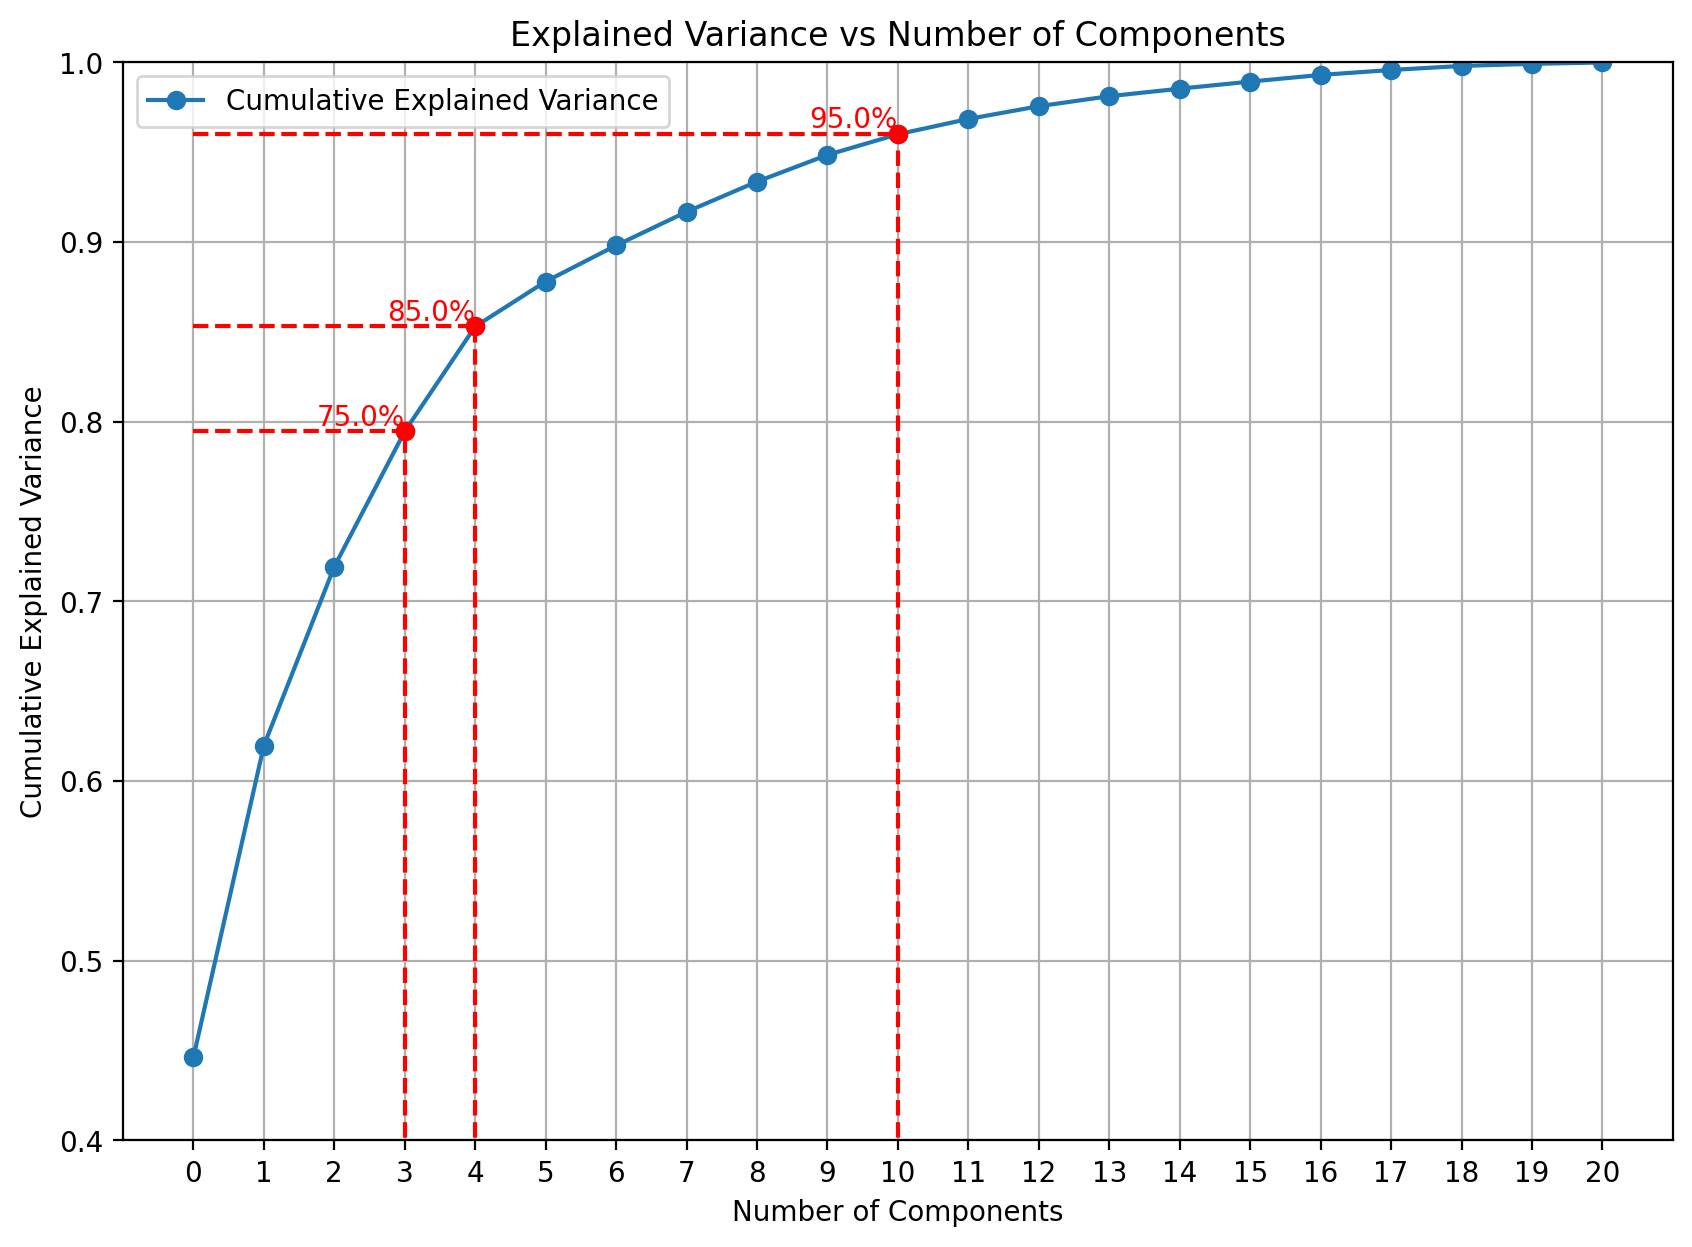

In [35]:
from sklearn.decomposition import PCA

target_names = ['Rating Average', 'Complexity Average', 'Popularity Score']
encoded_features = encoded.copy().drop(columns=target_names)
targets = encoded.copy()[target_names]

# Apply PCA
pca = PCA()
_ = pca.fit(encoded_features)

# Get the explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
_ = plt.figure(figsize=(10, 7))
_ = plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance')

# Define the thresholds for 75%, 85%, and 95% variance
thresholds = [0.75, 0.85, 0.95]

for threshold in thresholds:
    # Find the number of components required to explain at least 'threshold' variance
    component_index = np.argmax(cumulative_variance >= threshold)

    # Mark the point with a red dot
    _ = plt.plot(component_index, cumulative_variance[component_index], 'ro')  # Red dot

    # Draw striped lines from the red dot to the axes
    _ = plt.plot([component_index, component_index], [0,cumulative_variance[component_index]], 'r--')  # Vertical line
    
    _ = plt.plot([0, component_index], [cumulative_variance[component_index], cumulative_variance[component_index]], 'r--')  # Horizontal line

    # Annotate the point
    _ = plt.text(component_index, cumulative_variance[component_index], f'{threshold*100}%',
             color='r', ha='right', va='bottom')

# Labeling and displaying the plot
_ = plt.xticks(np.arange(0, len(cumulative_variance), 1))
_ = plt.ylim(0.4, 1)
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Cumulative Explained Variance')
_ = plt.title('Explained Variance vs Number of Components')
plt.grid(True)
_ = plt.legend()
plt.show()


In [36]:
from sklearn.feature_selection import SelectKBest, f_classif

datasets = {
    'original': encoded_features,
    
    # Volgende Datasets zijna getest geweest, maar hadden geen positieve invloed op de RMSE, MAE of R2 score
    # 'pca_95': PCA(n_components=0.95).fit_transform(encoded_features),
    # 'pca_90': PCA(n_components=0.90).fit_transform(encoded_features),
    # 'ANOVA_avg_rating_8': SelectKBest(f_classif, k=8).fit_transform(encoded_features, targets['Rating Average'] ),
    # 'ANOVA_avg_rating_10': SelectKBest(f_classif, k=10).fit_transform(encoded_features, targets['Rating Average'] ),
    # 'ANOVA_avg_rating_12': SelectKBest(f_classif, k=12).fit_transform(encoded_features, targets['Rating Average'] ),
    # 'ANOVA_complexity_rating_12': SelectKBest(f_classif, k=12).fit_transform(encoded_features, targets['Complexity Average'] ),
    # 'ANOVA_popularity_12': SelectKBest(f_classif, k=12).fit_transform(encoded_features, targets['Popularity Score'] ),
    # 'without_domains': encoded_features.drop(columns=[col for col in encoded_features.columns if col.startswith('Domains')]),
}

Uit de resultaten hieronder blijft dat dimensionality reduction geen positieve invloed op de resultaten heeft.

### 4.3 Model Training and Evaluation

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


def train_and_evaluate_models(datasets, targets, test_train_ratio, models):
    results = []
    
    for dataset_name, dataset in datasets.items():
        print(f"Processing Dataset: {dataset_name}")
        for target in targets.columns:
    
            print(f"\tProcessing target column: {target}")
    
            X = dataset
            y = targets[target]
    
            # Splitting dataset into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_ratio, random_state=42)
    
            for model_name, model in models.items():
                print(f"\t\tTraining model: {model_name}")
                model.fit(X_train, y_train)
    
                # Making predictions
                y_pred = model.predict(X_test)
    
                # Calculating evaluation metrics
                rmse = root_mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
    
                # Appending metrics
                metrics = {
                    'Dataset': dataset_name,
                    'Target': target, 
                    'Model Name': model_name, 
                    'Model': model, 
                    'RMSE': rmse,
                    'MAE': mae, 
                    'R2': r2}
    
                # Save results for the target column
                results.append(metrics)

    return results


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Define models
model_dict = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
}

# Run method
evaluation_results = train_and_evaluate_models(datasets, targets, 0.2, model_dict)


Processing Dataset: original
	Processing target column: Rating Average
		Training model: Linear Regression
		Training model: Random Forest
		Training model: Support Vector Regressor
		Training model: KNeighbors Regressor
		Training model: Decision Tree
		Training model: AdaBoostRegressor
		Training model: GradientBoostingRegressor
	Processing target column: Complexity Average
		Training model: Linear Regression
		Training model: Random Forest
		Training model: Support Vector Regressor
		Training model: KNeighbors Regressor
		Training model: Decision Tree
		Training model: AdaBoostRegressor
		Training model: GradientBoostingRegressor
	Processing target column: Popularity Score
		Training model: Linear Regression
		Training model: Random Forest
		Training model: Support Vector Regressor
		Training model: KNeighbors Regressor
		Training model: Decision Tree
		Training model: AdaBoostRegressor
		Training model: GradientBoostingRegressor


In [41]:
def best_dataset_and_model(df):
    """
    Prints the best Dataset and Model Name for each Target based on RMSE, MAE, and R2 metrics.

    Args:
        df (pd.DataFrame): Dataframe containing the columns: Dataset, Target, Model Name, RMSE, MAE, and R2.

    """
    # Validate input dataframe
    required_columns = {'Dataset', 'Target', 'Model Name', 'RMSE', 'MAE', 'R2'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    # Group by Target
    grouped = df.groupby('Target')

    # Iterate through each Target group
    for target, group in grouped:
        print(f"\nTarget: {target}")

        # Find the best entries for each metric
        best_rmse = group.loc[group['RMSE'].idxmin()]  # Lower is better for RMSE
        best_mae = group.loc[group['MAE'].idxmin()]    # Lower is better for MAE
        best_r2 = group.loc[group['R2'].idxmax()]      # Higher is better for R2

        # Print the results
        print(f"Best RMSE -> Dataset: {best_rmse['Dataset']}, Model: {best_rmse['Model Name']}, RMSE: {best_rmse['RMSE']:.3}")
        print(f"Best MAE  -> Dataset: {best_mae['Dataset']}, Model: {best_mae['Model Name']}, MAE: {best_mae['MAE']:.3}")
        print(f"Best R2   -> Dataset: {best_r2['Dataset']}, Model: {best_r2['Model Name']}, R2: {best_r2['R2']:.3}")


results = pd.DataFrame(evaluation_results, columns=['Dataset','Target', 'Model Name', 'RMSE', 'MAE', 'R2'])
best_dataset_and_model(results)


Target: Complexity Average
Best RMSE -> Dataset: original, Model: Support Vector Regressor, RMSE: 0.5
Best MAE  -> Dataset: original, Model: Support Vector Regressor, MAE: 0.361
Best R2   -> Dataset: original, Model: Support Vector Regressor, R2: 0.649

Target: Popularity Score
Best RMSE -> Dataset: original, Model: GradientBoostingRegressor, RMSE: 2.1
Best MAE  -> Dataset: original, Model: GradientBoostingRegressor, MAE: 1.72
Best R2   -> Dataset: original, Model: GradientBoostingRegressor, R2: 0.4

Target: Rating Average
Best RMSE -> Dataset: original, Model: GradientBoostingRegressor, RMSE: 0.668
Best MAE  -> Dataset: original, Model: Support Vector Regressor, MAE: 0.507
Best R2   -> Dataset: original, Model: GradientBoostingRegressor, R2: 0.454


### 4.4 Hypertuning

In [58]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error


def evaluate_hypertuned_model(original_results, best_model, X_test, y_test):

    # Generate predictions
    y_pred = best_model.predict(X_test)

    # Compute evaluation metrics
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))  # Root Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred)       # Mean Absolute Error
    r2 = r2_score(y_test, y_pred)                   # R² Score

    print("Evaluation Results:")
    print(f"{"RMSE:":5}{original_results['RMSE']: .3f} --> {rmse:.3f}")
    print(f"{"MAE:":5}{original_results['MAE']: .3f} --> {mae:.3f}")
    print(f"{"R2:":5}{original_results['R2']: .3f} --> {r2:.3f}")
    

#### 4.4.1 SVR - Complexity Average

In [60]:
from sklearn.model_selection import GridSearchCV

TARGET = "Complexity Average"
DATASET = 'original'
MODEL = 'Support Vector Regressor'

original_result = next((item for item in evaluation_results 
                        if item['Target'] == TARGET
                        and item["Dataset"] == DATASET 
                        and item["Model Name"] == MODEL
                        ), None)


X_train, X_test, y_train, y_test = train_test_split(datasets['original'], targets['Complexity Average'], test_size=0.1, random_state=42)

svr_param_grid_v1 = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
# Best parameters for SVR: {'C': 1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

svr_param_grid_v2 = {
    'C': [0.5, 1, 2.5, 5],
    'epsilon': [0.05, 0.1, 0.25, 5],
    'kernel': ['rbf'],
    'gamma': ['auto']
}
# Best parameters for SVR: {'C': 2.5, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

svr_param_grid_v3 = {
    'C': np.arange(1, 5, 0.5),
    'epsilon': [0.1],
    'kernel': ['rbf'],
    'gamma': ['auto']
}
# Best parameters for SVR: {'C': 3.0, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

svr = SVR()
grid_search_svr = GridSearchCV(estimator=svr, 
                               param_grid=svr_param_grid_v3,
                               scoring='r2',
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)

_ = grid_search_svr.fit(X_train, y_train)

# Best parameters
print("Best parameters for SVR:", grid_search_svr.best_params_)

ca_svr_best_model = grid_search_svr.best_estimator_

evaluate_hypertuned_model(original_result ,ca_svr_best_model, X_test, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for SVR: {'C': 3.0, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Evaluation Results:
RMSE: 0.500 --> 0.492
MAE:  0.361 --> 0.357
R2:   0.649 --> 0.649


#### 4.4.2 GradientBoostingRegressor - Popularity Score

In [64]:
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error r2_score

TARGET = "Popularity Score"
DATASET = 'original'
MODEL = 'Support Vector Regressor'

original_result = next((item for item in evaluation_results
                        if item['Target'] == TARGET
                        and item["Dataset"] == DATASET
                        and item["Model Name"] == MODEL
                        ), None)


X_train, X_test, y_train, y_test = train_test_split(datasets['original'], targets['Complexity Average'], test_size=0.1, random_state=42)


def optimize_gradient_boosting(X_train, y_train, param_space):
    model = GradientBoostingRegressor()

    opt = BayesSearchCV(
        model, 
        param_space, 
        n_iter=100, 
        cv=5, 
        n_jobs=-1, 
        verbose=1,
        random_state=42,
        scoring='r2'
    )

    _ = opt.fit(X_train, y_train)

    print("Best Hyperparameters:", opt.best_params_)

    return opt

params_v1 = {
    'learning_rate': (0.001, 0.1, 'uniform'),  
    'max_depth': (3, 10), # Maximum depth of the trees
    'min_samples_split': (2, 10), # Minimum number of samples required to split a node
    'min_samples_leaf': (1, 10), # Minimum number of samples required to be a leaf node
    'n_estimators': (50, 500),  # Number of trees
    'subsample': (0.5, 1.0), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters:
#   'learning_rate': 0.017720742925919214, 
#   'max_depth': 6, 
#   'min_samples_leaf': 5, 
#   'min_samples_split': 10,
#   'n_estimators': 500, 
#   'subsample': 0.5

params_v2 = {
    'learning_rate': (0.001, 0.05, 'uniform'),
    'max_depth': (4, 8), # Maximum depth of the trees
    'min_samples_leaf': (3, 8), # Minimum number of samples required to be a leaf node
    'min_samples_split': (5, 20), # Minimum number of samples required to split a node
    'n_estimators': (250, 1000),  # Number of trees
    'subsample': (0.2, 0.8), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
#   'learning_rate': 0.008312666315406367,
#   'max_depth': 8,
#   'min_samples_leaf': 3,
#   'min_samples_split': 19,
#   'n_estimators': 710,
#   'subsample': 0.5025436023522052})

params_v3 = {
    'learning_rate': (0.001, 0.015, 'uniform'),
    'max_depth': (5, 10), # Maximum depth of the trees
    'min_samples_leaf': (1, 5), # Minimum number of samples required to be a leaf node
    'min_samples_split': (15, 22), # Minimum number of samples required to split a node
    'n_estimators': (500, 1000),  # Number of trees
    'subsample': (0.4, 0.7), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
#   'learning_rate': 0.009947694073801413, 
#   'max_depth': 7, 
#   'min_samples_leaf': 5, 
#   'min_samples_split': 15, 
#   'n_estimators': 734, 
#   'subsample': 0.4

params_v4 = {
    'learning_rate': (0.007, 0.012, 'uniform'),
    'max_depth': (6, 9), # Maximum depth of the trees
    'min_samples_leaf': (3, 7), # Minimum number of samples required to be a leaf node
    'min_samples_split': (13, 21), # Minimum number of samples required to split a node
    'n_estimators': (625, 825),  # Number of trees
    'subsample': (0.3, 0.6), # Fraction of samples to use for fitting each tree
}


gbr = optimize_gradient_boosting(X_train, y_train, params_v4)
ps_bgr_best_model = gbr.best_estimator_

evaluate_hypertuned_model(original_result, ps_bgr_best_model, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

#### 4.4.2 GradientBoostingRegressor - Rating Average